## Part 1: Data Processing and Model Training
This notebook covers the full end-to-end pipeline, including data cleaning, sentiment model fine-tuning (DistilBERT), clustering (HDBSCAN), and the training of the proxy model (RandomForest) for explainability.

In [ ]:
!pip install umap-learn hdbscan textblob
!pip install catboost shap --quiet
!pip install -U transformers

import pandas as pd
import numpy as np
import torch, os
import umap
import hdbscan
import shap
import joblib
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support,classification_report
from sklearn.ensemble import RandomForestClassifier



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 156.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


**LOAD AND PREPROCESS**

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/retail_data.csv')


# Filter for country USA
df = df[df['Country'].str.strip().str.lower() == 'usa']

# Strip whitespace from all string columns
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


# Drop rows missing either Feedback or Ratings
df = df.dropna(subset=["Feedback", "Ratings"])
df = df[(df["Feedback"].astype(str).str.strip() != "") & (df["Ratings"].astype(str).str.strip() != "")]


df = df.dropna(subset=["Feedback", "Ratings"])
df = df[df["Feedback"].astype(str).str.strip() != ""]

# Convert all string columns to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


# Drop unnecessary columns
cols_to_drop = ['Name', 'Phone', 'Address', 'Email','Income','Time','City','Shipping_Method','Customer_Segment','Order_Status']
df = df.drop(columns=cols_to_drop, errors='ignore')



# Drop duplicate rows
df = df.drop_duplicates()

# Build features (super simple example: frequency & monetary)
customer = df.groupby("Customer_ID").agg({
    "Transaction_ID": "count",
    "Amount": "sum"
}).rename(columns={"TransactionID": "Frequency", "Amount Spent": "Monetary"})


# Encode Gender to 0 or 1 (male = 0, female = 1)
if 'Gender' in df.columns:
    df['Gender'] = df['Gender'].map({'male': 0, 'female': 1})

categorical_features = [
    'Gender', 'City', 'State', 'Country',
    'Product_Category', 'Product_Brand', 'Product_Type',
    'Shipping_Method', 'Payment_Method', 'Order_Status', 'Feedback'
]

# Ensure categorical columns are strings
for col in categorical_features:
    if col in df.columns:
        df[col] = df[col].astype(str)

# Fill missing values
customer = customer.fillna(0)



/tmp/ipython-input-405937977.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/tmp/ipython-input-405937977.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


SAVE CLEANED DATA


In [ ]:
# Save the cleaned data
df.to_csv("/content/drive/MyDrive/Colab Notebooks/trained_results/retail_data_cleaned.csv", index=False)

print("Preprocessing complete")
print("Remaining rows:", len(df))
print(df.columns)

Preprocessing complete
Remaining rows: 95155
Index(['Transaction_ID', 'Customer_ID', 'State', 'Zipcode', 'Country', 'Age',
       'Gender', 'Date', 'Year', 'Month', 'Total_Purchases', 'Amount',
       'Total_Amount', 'Product_Category', 'Product_Brand', 'Product_Type',
       'Feedback', 'Payment_Method', 'Ratings', 'products'],
      dtype='object')


# *DistilBERT*

In [ ]:
# Label mapping from Ratings to sentiment
def map_rating_to_sentiment(r):
    try:
        r = float(r)
    except:
        return np.nan
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    elif r >= 4:
        return "positive"
    else:
        return np.nan

df["label_str"] = df["Ratings"].apply(map_rating_to_sentiment)
df = df.dropna(subset=["label_str"])

# Create label mapping
unique_labels = sorted(df["label_str"].unique())
label_map = {lbl:i for i,lbl in enumerate(unique_labels)}
id2label = {i:lbl for lbl,i in label_map.items()}
df["label"] = df["label_str"].map(label_map)

print("\nLabel mapping:", label_map)
print("Counts:\n", df["label_str"].value_counts())

#training on small subset

df = df.sample(n=500, random_state=42).reset_index(drop=True)

#train/test split

train_df, test_df = train_test_split(df[["Feedback","label"]], test_size= 0.2, random_state=42, stratify=df["label"])

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))


Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}
Counts:
 label_str
positive    42701
negative    36011
neutral     16443
Name: count, dtype: int64


In [ ]:
# Tokenization

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["Feedback"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

cols = ["input_ids","attention_mask","label"]
train_dataset = train_dataset.remove_columns([c for c in train_dataset.column_names if c not in cols])
test_dataset = test_dataset.remove_columns([c for c in test_dataset.column_names if c not in cols])

train_dataset.set_format("torch")
test_dataset.set_format("torch")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

# **load Pretrained model and calculate metrics**

In [ ]:
# Load model
num_labels = len(label_map)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label_map
)

# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# TRAINING AND EVALUATION

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,               # change this if you want longer training
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-2313926059.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train
trainer.train()

# Evaluate
print("\nFinal Evaluation:")
metrics = trainer.evaluate()
print(metrics)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.751100,0.401100,0.810000,0.675538,0.810000,0.731261
2,0.377900,0.288374,0.860000,0.919394,0.860000,0.866282
3,0.317300,0.274958,0.860000,0.919394,0.860000,0.866282


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Final Evaluation:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.2883737087249756, 'eval_accuracy': 0.86, 'eval_precision': 0.9193939393939394, 'eval_recall': 0.86, 'eval_f1': 0.8662820512820514, 'eval_runtime': 9.9295, 'eval_samples_per_second': 10.071, 'eval_steps_per_second': 0.705, 'epoch': 3.0}


## SAVE AND TEST TRAINED SENTIMENT MODEL

In [ ]:
# Save model
save_dir = "/content/drive/MyDrive/Colab Notebooks/sentiment_model_5%"
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"\nModel saved to: {save_dir}")

# Quick test prediction
examples = [
    "the quality of the clothes was average",
    "excellent is the only way i can describe my experience",
    "bad",
    "yeah it was so good"
]
enc = tokenizer(examples, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    logits = model(**enc).logits
preds = logits.argmax(-1).tolist()
print("\nSample predictions:")
for t,p in zip(examples, preds):
    print(f" - {t} -> {id2label[p]}")


Model saved to: /content/drive/MyDrive/Colab Notebooks/sentiment_model_5%

Sample predictions:
 - the quality of the clothes was average -> negative
 - excellent is the only way i can describe my experience -> positive
 - bad -> negative
 - yeah it was so good -> positive


# **TRAIN SHAP MODEL**

In [ ]:
# Load the CLEANED dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/trained_results/retail_data_cleaned.csv')


categorical_features = [
    'Gender', 'City', 'State', 'Country',
    'Product_Category', 'Product_Brand', 'Product_Type',
    'Shipping_Method', 'Payment_Method', 'Order_Status', 'Feedback'
]

# Ensure categorical columns are strings
for col in categorical_features:
    if col in df.columns:
        df[col] = df[col].astype(str)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

X_numeric = df.select_dtypes(include='number')

# Impute missing numerical values before scaling
imputer = SimpleImputer(strategy='mean')
X_numeric_imputed = imputer.fit_transform(X_numeric)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric_imputed)

df['Segment_ID'] = KMeans(n_clusters=4, random_state=42).fit_predict(X_scaled)

# Automatically detect object-type columns
categorical_features = df.select_dtypes(include='object').columns.tolist()
print("Categorical features:", categorical_features)

for col in categorical_features:
    df[col] = df[col].astype(str)

df_sample = df.sample(frac=0.05, random_state=42)  # Use 5% of data
model = CatBoostClassifier(verbose=100)
model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, verbose=50)


df_sample = df.sample(frac=0.3, random_state=42)  # Use 30% of data
X = df_sample.drop(columns=['Segment_ID'])
y = df_sample['Segment_ID']
model = CatBoostClassifier(task_type='GPU', iterations=100, depth=6, verbose=50)



# Ensure df_sample includes the 'Income_Level_Mapped' column
# Assuming df_sample was created from df after adding 'Income_Level_Mapped'
# If not, you might need to recreate df_sample or work with the full df

X = df_sample.drop(columns=['Segment_ID'])
y = df_sample['Segment_ID']

# Ensure 'Income_Level_Mapped' is treated as a numerical feature by default
# If you want to treat it as categorical, add 'Income_Level_Mapped' to categorical_features list
# For now, we will treat it as numerical based on the mapping

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(verbose=0)
# Pass categorical_features to the fit method
model.fit(X_train, y_train, cat_features=categorical_features)

ordinal_map = {'Low': 1, 'Medium': 2, 'High': 3}

if 'Income' in df.columns:
    df['Income_Level_Mapped'] = df['Income'].map(ordinal_map)
    # Optional: Drop the original 'Income' column if you only want the mapped values
    # df.drop(columns=['Income'], inplace=True)
else:
    print("'Income' column not found in the DataFrame.")

Categorical features: ['State', 'Country', 'Gender', 'Date', 'Month', 'Product_Category', 'Product_Brand', 'Product_Type', 'Feedback', 'Payment_Method', 'products']
'Income' column not found in the DataFrame.


In [ ]:
# Save the resulting DataFrame to a CSV file
output_path = '/content/drive/MyDrive/Colab Notebooks/trained_results/retail_data_segmented.csv'
df.to_csv(output_path, index=False)

print(f"File saved successfully to: {output_path}")

#save the model

model.save_model("/content/drive/MyDrive/Colab Notebooks/trained_models/catboost_segment_model5.cbm")
print("Model saved successfully!")

print(df.columns)


File saved successfully to: /content/drive/MyDrive/Colab Notebooks/trained_results/retail_data_segmented.csv
Model saved successfully!
Index(['Transaction_ID', 'Customer_ID', 'State', 'Zipcode', 'Country', 'Age',
       'Gender', 'Date', 'Year', 'Month', 'Total_Purchases', 'Amount',
       'Total_Amount', 'Product_Category', 'Product_Brand', 'Product_Type',
       'Feedback', 'Payment_Method', 'Ratings', 'products', 'Segment_ID'],
      dtype='object')


# **LOAD SAVED SHAP MODEL**

In [ ]:
# Load model
loaded_model = CatBoostClassifier()
loaded_model.load_model("/content/drive/MyDrive/Colab Notebooks/trained_models/catboost_segment_model5.cbm")

# Confirm it’s loaded
print("Model loaded successfully!")

# Predict new data
y_pred_new = loaded_model.predict(X_test)

scaler_path = "/content/drive/MyDrive/Colab Notebooks/trained_models/scaler.pkl"
joblib.dump(scaler, scaler_path)

# Load later
scaler = joblib.load(scaler_path)

Model loaded successfully!


# **RUNNING TRAINED SENTIMENT MODEL**

In [ ]:


#  Load  trained model
MODEL_DIR = "/content/drive/MyDrive/Colab Notebooks/sentiment_model2"
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

model.eval()  # set model to evaluation mode

#  Load  dataset
data_path = "/content/drive/MyDrive/Colab Notebooks/trained_results/retail_data_segmented.csv"
df = pd.read_csv(data_path)


# Clean feedback column
#df = df.dropna(subset=["Feedback"])
#df["Feedback"] = df["Feedback"].astype(str).str.strip().str.lower()

# 3. Run batch inference
def get_sentiment_predictions(texts, batch_size=32):
    results = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=256, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**encodings)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            preds = torch.argmax(probs, dim=1).tolist()

        # Convert to readable form
        for j, text in enumerate(batch_texts):
            results.append({
                "Feedback": text,
                "Predicted_Label": model.config.id2label[preds[j]],
                "Positive_Prob": probs[j][model.config.label2id.get("positive", 0)].item()
            })
    return pd.DataFrame(results)

# Generate predictions
sentiment_df = get_sentiment_predictions(df["Feedback"].tolist())

# Merge results back to your dataset
df = pd.concat([df.reset_index(drop=True), sentiment_df[["Predicted_Label", "Positive_Prob"]]], axis=1)

# Save updated dataset with sentiment
output_path = "/content/drive/MyDrive/Colab Notebooks/trained_results/retail_with_sentiment.csv"
df.to_csv(output_path, index=False)
print(f"Sentiment predictions saved to: {output_path}")


Sentiment predictions saved to: /content/drive/MyDrive/Colab Notebooks/trained_results/retail_with_sentiment.csv


**RUNNING HDBSCAN MODEL W/SENTIMENT COLUMNS AND GEO INFO TO CREATE CLUSTERS**

In [ ]:
#  Load dataset with sentiment
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trained_results/retail_with_sentiment.csv")

#  Select relevant features

features = [
    "Total_Purchases", "Total_Amount", "Age", "Positive_Prob"
]



X = df[features].fillna(0)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#UMAP (reduce dimensions)
reducer = umap.UMAP(n_neighbors=30, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10)
labels = clusterer.fit_predict(X_umap)
df["Cluster_ID"] = labels

#Then merge with US ZIP → lat/lon dataset
zip_us = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/USZipsWithLatLon_20231227.csv")  # your lookup file
df = df.merge(zip_us, left_on="Zipcode", right_on="postal code", how="left")


# Save clustered dataset
output_path = "/content/drive/MyDrive/Colab Notebooks/trained_results/retail_with_clusters(P).csv"
df.to_csv(output_path, index=False)
print(f"Clustered dataset saved to: {output_path}")

# Check cluster distribution
print(df["Cluster_ID"].value_counts())

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clustered dataset saved to: /content/drive/MyDrive/Colab Notebooks/trained_results/retail_with_clusters(P).csv
Cluster_ID
-1      8423
 73     2251
 400    2198
 57     1921
 575    1011
        ... 
 260      50
 448      50
 41       50
 406      50
 78       50
Name: count, Length: 595, dtype: int64


In [ ]:
#save cluster distribution to text file

with open("/content/drive/MyDrive/Colab Notebooks/trained_results/cluster_dist.txt", "w") as f:
    f.write(df["Cluster_ID"].value_counts().to_string())



**USING SHAP TO EXPLAIN**

we use the supervised model to learn cluster patterns

In [ ]:
# Load clustered dataset
clustered_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trained_results/retail_with_clusters(P).csv")

# Drop HDBSCAN noise points (-1 = noise)
if "Cluster_ID" in clustered_df.columns:
    clustered_df = clustered_df[clustered_df["Cluster_ID"] != -1]

# Select relevant features and target
features = ["Total_Purchases", "Total_Amount", "Age", "Positive_Prob"]
target = "Cluster_ID"

# Prepare feature and target matrices
X = clustered_df[features].fillna(0)
y = clustered_df[target]

# === Train RandomForest to Mimic the Clustering ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
print(" RandomForest trained successfully on clustered data.")

# Save model for reuse
rf_path = "/content/drive/MyDrive/Colab Notebooks/trained_models/randomforest_cluster_model.pkl"
joblib.dump(rf, rf_path)
print(f"Model saved to: {rf_path}")

# SHAP Explainability
explainer = shap.TreeExplainer(rf)

# Sample data for SHAP (limit for performance)
sample_size = min(1000, len(X))
X_sample = X.sample(n=sample_size, random_state=42)

print(f"Computing SHAP values for {sample_size} samples...")
shap_values = explainer.shap_values(X_sample)
print(" SHAP values computed successfully.")

# Save SHAP results
shap_path = "/content/drive/MyDrive/Colab Notebooks/trained_results/shap_values_rf.pkl"
joblib.dump(shap_values, shap_path)
print(f"SHAP values saved to: {shap_path}")

# Verify Shapes
print("Feature matrix shape:", X_sample.shape)
print("SHAP value shapes per class:", [sv.shape for sv in shap_values])



 RandomForest trained successfully on clustered data.
Model saved to: /content/drive/MyDrive/Colab Notebooks/trained_models/randomforest_cluster_model.pkl
Computing SHAP values for 1000 samples...
 SHAP values computed successfully.
SHAP values saved to: /content/drive/MyDrive/Colab Notebooks/trained_results/shap_values_rf.pkl
Feature matrix shape: (1000, 4)
SHAP value shapes per class: [(4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594), (4, 594),

In [ ]:
# Save model and shap values

joblib.dump(rf, "/content/drive/MyDrive/Colab Notebooks/trained_models/randomforest_cluster_model.pkl")
print("RandomForest model saved successfully!")

# Define the save path
shap_path = "/content/drive/MyDrive/Colab Notebooks/trained_results/shap_values_rf.pkl"

# Save SHAP values
joblib.dump(shap_values, shap_path)
print(f"SHAP values saved successfully to: {shap_path}")


RandomForest model saved successfully!
SHAP values saved successfully to: /content/drive/MyDrive/Colab Notebooks/trained_results/shap_values_rf.pkl


In [ ]:
# Load model later
rf_loaded = joblib.load("/content/drive/MyDrive/Colab Notebooks/trained_models/randomforest_cluster_model.pkl")
print("RandomForest model loaded successfully!")

RandomForest model loaded successfully!


# RESULTS OF MODEL

## Sentiment Analysis

<Figure size 1000x600 with 0 Axes>

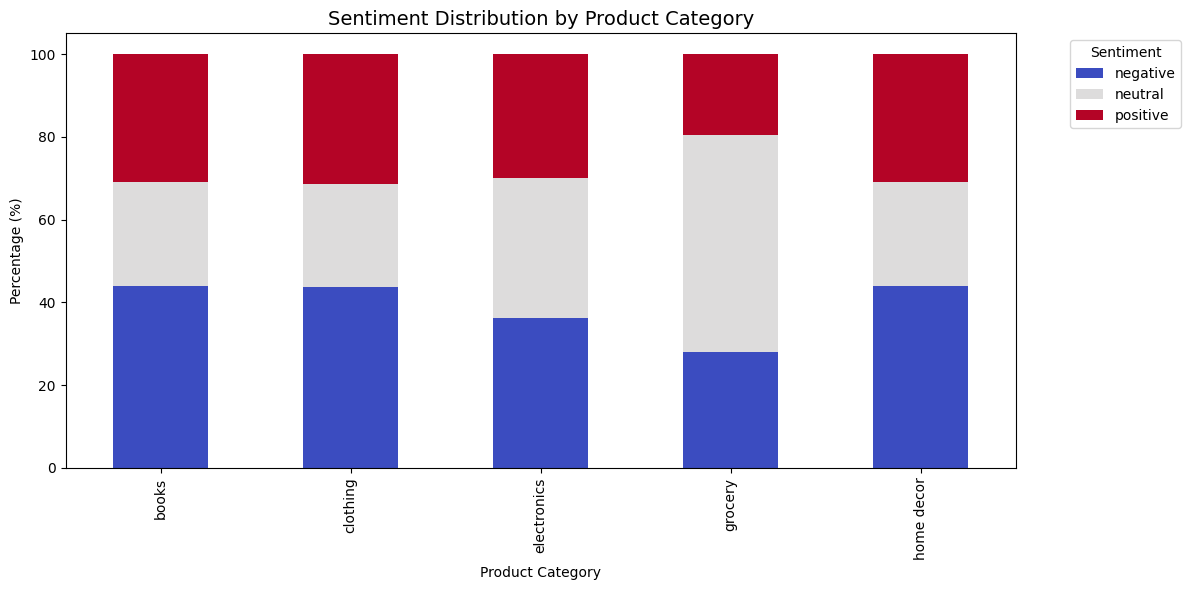

Predicted_Label   negative  neutral  positive
Product_Category                             
books                 44.0     25.2      30.8
clothing              43.7     25.0      31.4
electronics           36.1     34.0      29.9
grocery               27.9     52.6      19.5
home decor            43.9     25.2      30.9


In [ ]:


sentiment_result = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trained_results/retail_with_sentiment.csv")

# Count sentiment distribution by product category
sentiment_dist = sentiment_result.groupby(['Product_Category', 'Predicted_Label']).size().unstack(fill_value=0)

# Normalize to get percentages
sentiment_pct = sentiment_dist.div(sentiment_dist.sum(axis=1), axis=0) * 100

# Plot the percentage distribution
plt.figure(figsize=(10, 6))
sentiment_pct.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12,6))
plt.title("Sentiment Distribution by Product Category", fontsize=14)
plt.ylabel("Percentage (%)")
plt.xlabel("Product Category")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print numeric summary
print(sentiment_pct.round(1))

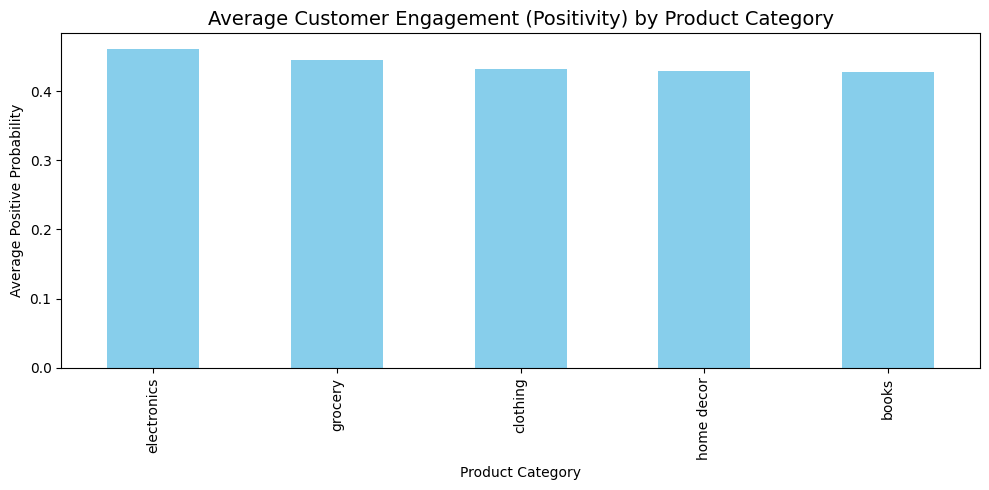

Product_Category
electronics    0.460
grocery        0.446
clothing       0.432
home decor     0.428
books          0.428
Name: Positive_Prob, dtype: float64


In [ ]:
# Average positivity score by product category
engagement_by_product = sentiment_result.groupby('Product_Category')['Positive_Prob'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
engagement_by_product.plot(kind='bar', color='skyblue')
plt.title("Average Customer Engagement (Positivity) by Product Category", fontsize=14)
plt.ylabel("Average Positive Probability")
plt.xlabel("Product Category")
plt.tight_layout()
plt.show()

# Print table
print(engagement_by_product.round(3))

Customer engagement, measured as average positivity, is strongest for home decor and books showing that these categories generate the most emotional satisfaction.

# HDB

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


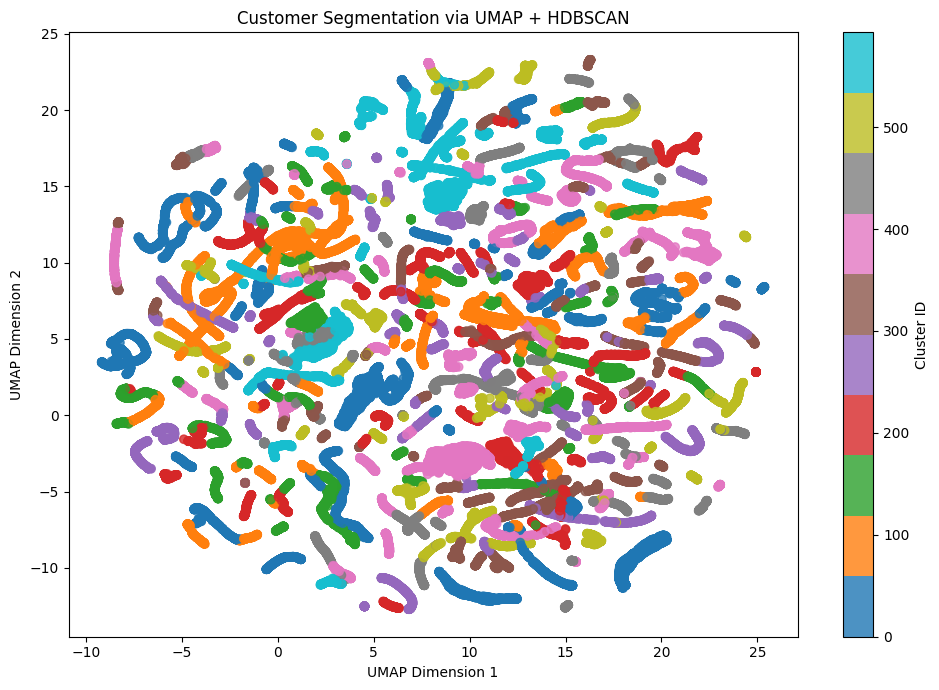

            Total_Purchases  Total_Amount    Age  Positive_Prob  Count
Cluster_ID                                                            
0                     10.00       2426.94  21.56           0.48    824
1                      8.00       2043.20  21.45           0.48    824
2                      4.00       1764.04  18.88           0.00     69
3                      1.00        132.11  18.75           1.00     83
4                      1.00        383.87  18.86           1.00     92
...                     ...           ...    ...            ...    ...
589                   10.00       4445.36  57.94           0.00     50
590                    9.77       3905.76  64.60           0.00     77
591                    9.00       2933.64  61.97           0.00     78
592                    9.29       1758.77  61.84           0.00    116
593                    9.26        601.79  58.30           0.00    174

[594 rows x 5 columns]


In [ ]:


# Load clustered dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trained_results/retail_with_clusters(P).csv")

# Filter out noise points (-1 means "noise" in HDBSCAN)
df = df[df["Cluster_ID"] != -1]

# 2D coordinates from UMAP already computed during clustering (optional: recompute)
features = ["Total_Purchases", "Total_Amount", "Age", "Positive_Prob"]

# Re-run UMAP if needed
import umap
from sklearn.preprocessing import StandardScaler

X = df[features].fillna(0)
X_scaled = StandardScaler().fit_transform(X)
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Add to dataframe
df["UMAP_1"] = X_umap[:, 0]
df["UMAP_2"] = X_umap[:, 1]

# Scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df["UMAP_1"], df["UMAP_2"], c=df["Cluster_ID"], cmap="tab10", alpha=0.8)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Customer Segmentation via UMAP + HDBSCAN")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()


# Select relevant metrics
cluster_summary = df.groupby("Cluster_ID").agg({
    "Total_Purchases": "mean",
    "Total_Amount": "mean",
    "Age": "mean",
    "Positive_Prob": "mean"
}).round(2)

# Add total members per cluster
cluster_summary["Count"] = df["Cluster_ID"].value_counts().sort_index()

print(cluster_summary)



# SHAP/RF

In [ ]:
# Visualize top features


# Load SHAP values and clustered data
shap_values = joblib.load("/content/drive/MyDrive/Colab Notebooks/trained_results/shap_values_rf.pkl")
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trained_results/retail_with_clusters(P).csv")

# Select the same features used for training
features = ["Total_Purchases", "Total_Amount", "Age", "Positive_Prob"]
X = df[features].fillna(0)

# Global feature importance summary
shap.summary_plot(shap_values, X, plot_type="bar", max_display=10, show=False)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/trained_results/global_feature_importance.png", dpi=300, bbox_inches="tight")
plt.close()



/tmp/ipython-input-2801920826.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, plot_type="bar", max_display=10, show=False)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipython-input-2801920826.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


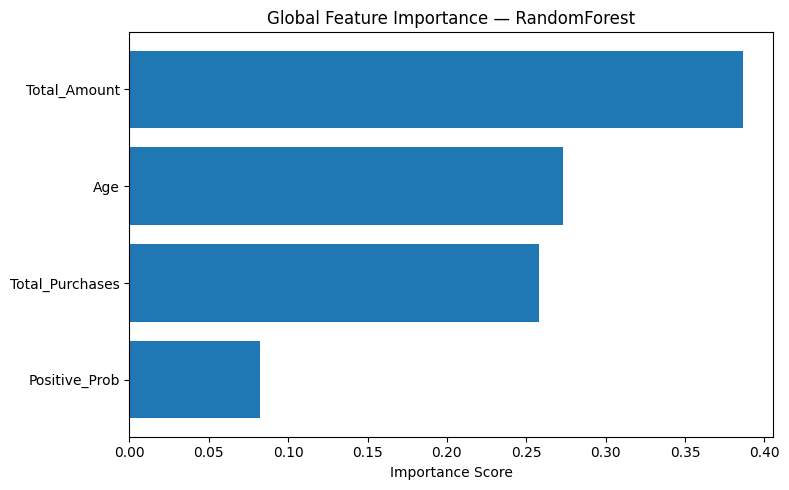

           Feature  Importance
1     Total_Amount    0.386361
2              Age    0.273208
0  Total_Purchases    0.257891
3    Positive_Prob    0.082539


In [ ]:


importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(8,5))
plt.barh(importance['Feature'], importance['Importance'])
plt.title("Global Feature Importance — RandomForest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/trained_results/global_feature_importance.png", dpi=300, bbox_inches="tight")
plt.close()
print(importance.sort_values('Importance', ascending=False))


How does location affect feedback?

Index(['Transaction_ID', 'Customer_ID', 'State', 'Zipcode', 'Country', 'Age',
       'Gender', 'Date', 'Year', 'Month', 'Total_Purchases', 'Amount',
       'Total_Amount', 'Product_Category', 'Product_Brand', 'Product_Type',
       'Feedback', 'Payment_Method', 'Ratings', 'products', 'Segment_ID',
       'Predicted_Label', 'Positive_Prob', 'Cluster_ID', 'country code',
       'postal code', 'place name', 'admin name1', 'admin code1',
       'admin name2', 'admin code2', 'latitude', 'longitude'],
      dtype='object')
State
delaware         0.554859
utah             0.546549
nebraska         0.545143
new jersey       0.541473
nevada           0.541207
massachusetts    0.540272
south dakota     0.538359
hawaii           0.534696
illinois         0.533261
alabama          0.532868
Name: Positive_Prob, dtype: float64


/tmp/ipython-input-517472317.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_by_state.index, y=sentiment_by_state.values, palette="coolwarm")


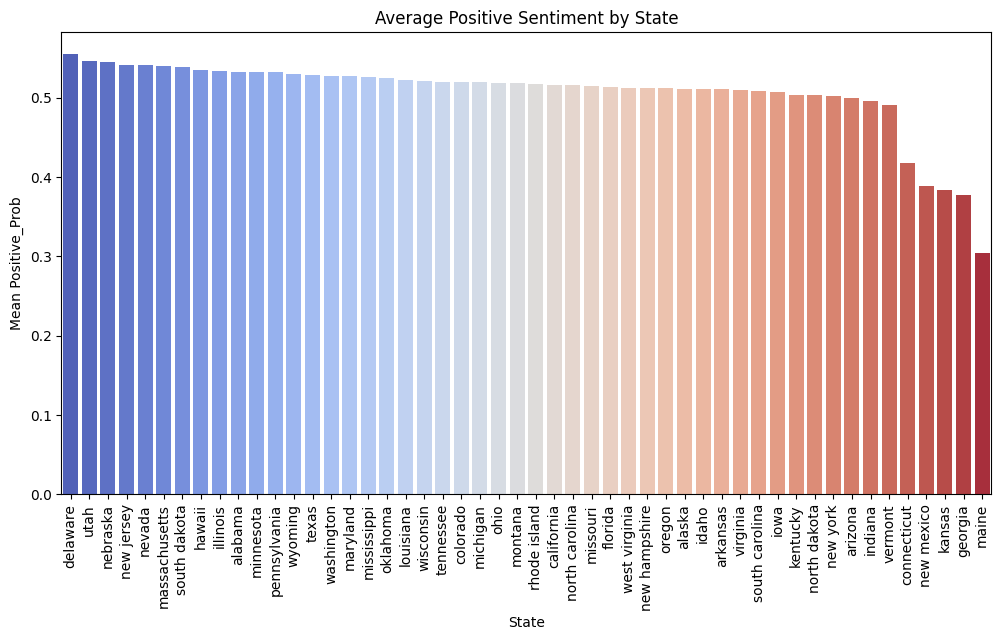

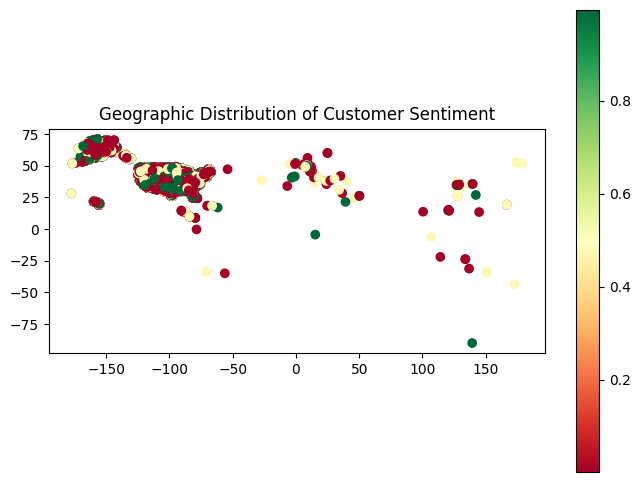

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:123: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self._figure.tight_layout(*args, **kwargs)


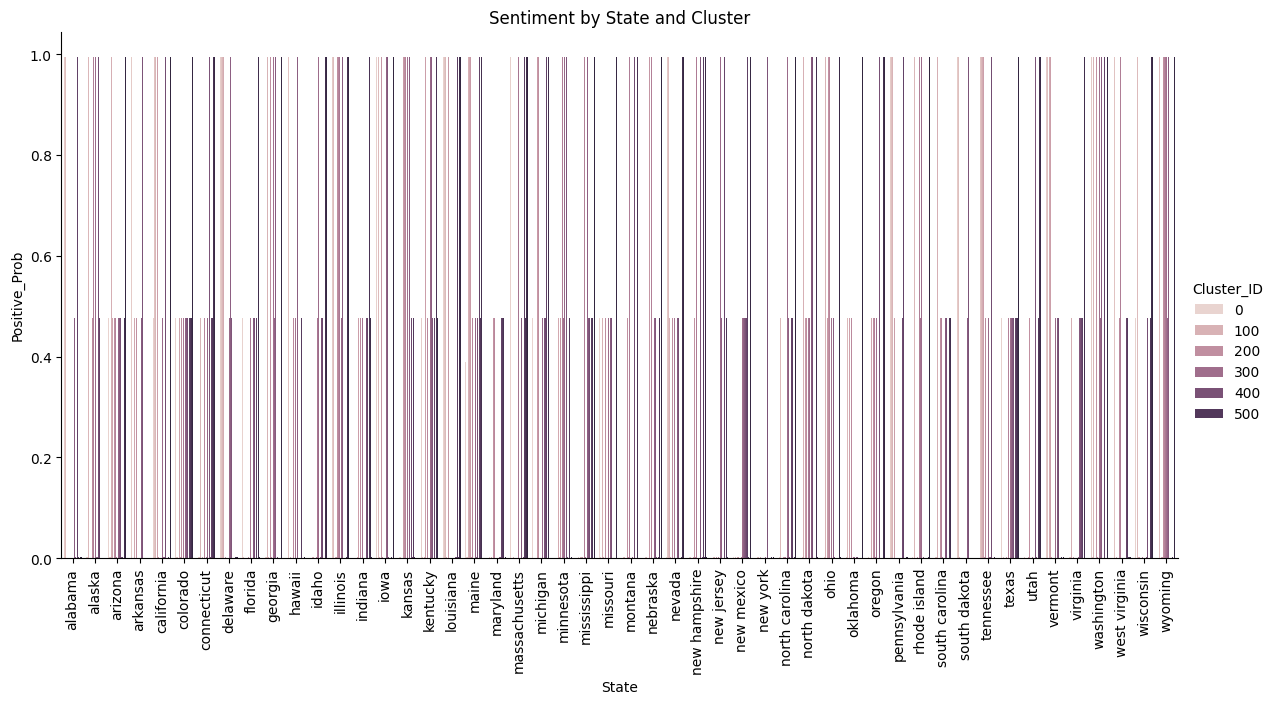

In [ ]:
import seaborn as sns
import geopandas as gpd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trained_results/retail_with_clusters(P).csv")
print(df.columns)

# Average positivity by region
sentiment_by_state = df.groupby("State")["Positive_Prob"].mean().sort_values(ascending=False)


print(sentiment_by_state.head(10))





plt.figure(figsize=(12,6))
sns.barplot(x=sentiment_by_state.index, y=sentiment_by_state.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Average Positive Sentiment by State")
plt.ylabel("Mean Positive_Prob")
plt.show()



# Assuming 'latitude' and 'longitude' exist
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.plot(column='Positive_Prob', cmap='RdYlGn', legend=True, figsize=(8,6))
plt.title("Geographic Distribution of Customer Sentiment")
plt.show()


#how clusters differ geographically:
geo_cluster_sent = df.groupby(["State", "Cluster_ID"])["Positive_Prob"].mean().reset_index()
sns.catplot(data=geo_cluster_sent, x="State", y="Positive_Prob", hue="Cluster_ID", kind="bar", height=6, aspect=2)
plt.xticks(rotation=90)
plt.title("Sentiment by State and Cluster")
plt.show()



/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


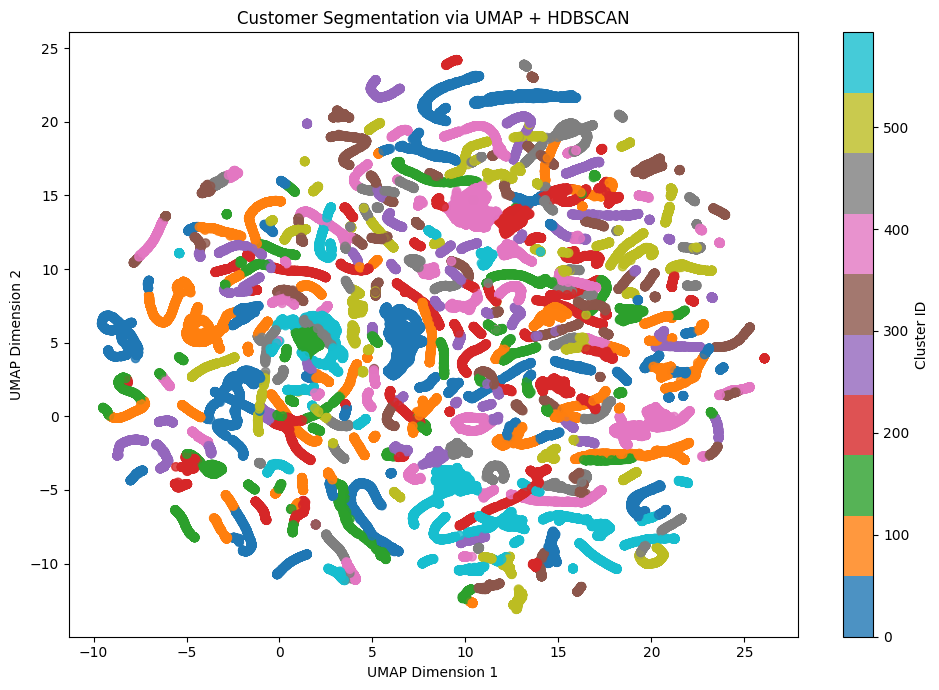

In [ ]:
import umap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset with sentiment and clusters
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trained_results/retail_with_clusters(P).csv")

# Filter out noise points (-1 means "noise" in HDBSCAN)
df = df[df["Cluster_ID"] != -1]

# Select relevant features for UMAP reduction
features = [
    "Total_Purchases", "Total_Amount", "Age", "Positive_Prob"
]
X = df[features].fillna(0)

# Standardize the features
X_scaled = StandardScaler().fit_transform(X)

# Re-run UMAP to get 2D coordinates
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Add UMAP coordinates to the dataframe
df["UMAP_1"] = X_umap[:, 0]
df["UMAP_2"] = X_umap[:, 1]

# Create the scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df["UMAP_1"], df["UMAP_2"], c=df["Cluster_ID"], cmap="tab10", alpha=0.8)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Customer Segmentation via UMAP + HDBSCAN")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


<Figure size 800x600 with 0 Axes>

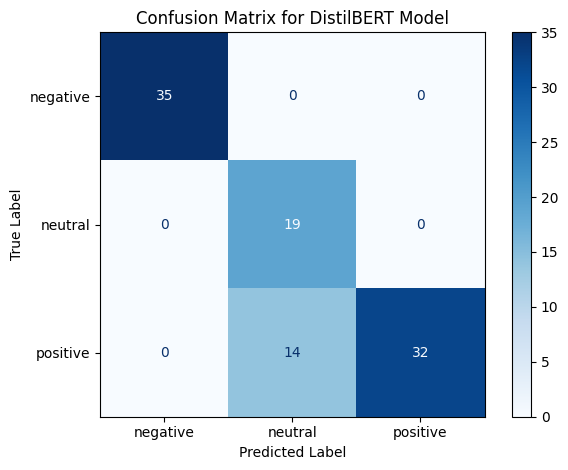

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions on the test set
predictions = trainer.predict(test_dataset)

# Extract predicted labels (from logits) and true labels
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids

# Get the class names from id2label (e.g., {0: 'negative', 1: 'neutral', 2: 'positive'})
class_names = [id2label[i] for i in sorted(id2label.keys())]

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display_cm.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for DistilBERT Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

/tmp/ipython-input-3818518516.py:53: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


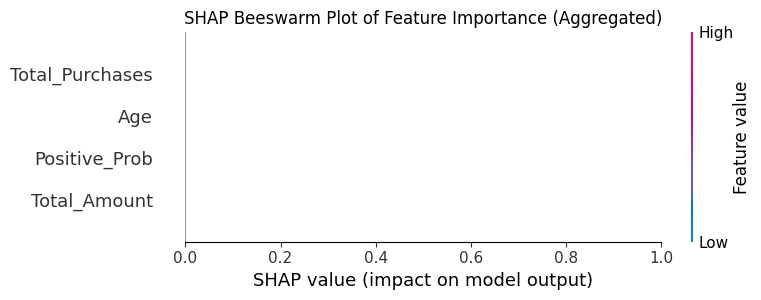

In [ ]:
import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# Load SHAP values and clustered data
shap_values = joblib.load("/content/drive/MyDrive/Colab Notebooks/trained_results/shap_values_rf.pkl")
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trained_results/retail_with_clusters(P).csv")

# Select the same features used for training the RandomForest model
features = ["Total_Purchases", "Total_Amount", "Age", "Positive_Prob"]
X = df[features].fillna(0)

# Ensure X_sample used for SHAP values matches the order and indices of X
# (assuming shap_values were computed on X_sample as done previously)
# For the summary plot, we need to pass the background data (X_sample)
# or a subset of X that was used to compute the shap_values.
# Let's recreate X_sample from X to ensure consistency
# sample_size was 1000 in the previous step
sample_size = min(1000, len(X))
X_sample_for_plot = X.sample(n=sample_size, random_state=42)

# --- Corrected SHAP Value Aggregation ---
# For multi-class models, explainer.shap_values() typically returns a LIST of arrays,
# where each array in the list corresponds to the SHAP values for one class,
# and each of these arrays has shape (num_samples, num_features).
# To get a single global importance plot, we need to stack them and average.

# First, stack the list of arrays into a 3D array: (num_classes, num_samples, num_features)
# Check if shap_values is a list. If not, it might already be a stacked array.
if isinstance(shap_values, list):
    # Stack along a new axis (0) to get (num_classes, num_samples, num_features)
    stacked_shap_values = np.stack(shap_values, axis=0)
    # Now, take the mean absolute value across the class dimension (axis=0)
    # Resulting shape: (num_samples, num_features)
    aggregated_shap_values = np.abs(stacked_shap_values).mean(axis=0)
elif isinstance(shap_values, np.ndarray):
    # If it's already a 3D array, assume it's (num_samples, num_features, num_classes)
    # and average across the last axis (classes).
    # This is often the case when shap_values are directly saved/loaded after being computed
    # into a single 3D tensor by libraries like `transformers` or if the explainer output is reshaped.
    if shap_values.ndim == 3 and shap_values.shape[0] == sample_size and shap_values.shape[1] == len(features):
        aggregated_shap_values = np.abs(shap_values).mean(axis=2)
    else:
        raise ValueError(f"Unexpected ndarray shape for shap_values: {shap_values.shape}")
else:
    raise TypeError(f"shap_values is neither a list nor an ndarray: {type(shap_values)}")


# SHAP Summary Plot (Beeswarm Plot)
plt.figure(figsize=(10, 7))
shap.summary_plot(
    aggregated_shap_values,
    X_sample_for_plot, # Pass the DataFrame directly
    feature_names=features, # Explicitly pass feature names
    plot_type="beeswarm",
    show=False # We handle plt.show() explicitly at the end
)
plt.title("SHAP Beeswarm Plot of Feature Importance (Aggregated)")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/trained_results/shap_beeswarm_plot.png", dpi=300, bbox_inches="tight")
plt.show()

# Task
Prepare segment data by selecting cluster IDs 0, 3, and 590, renaming them to 'Young Average Spenders', 'New Enthusiasts', and 'Disgruntled High-Spenders' respectively, and extracting their average 'Total_Amount', 'Positive_Prob', and 'Age' from the `cluster_summary` DataFrame.

## Prepare Segment Data

### Subtask:
Select specific cluster IDs, rename them for clarity (e.g., 'Young Average', 'New Enthusiasts', 'Disgruntled High-Spenders'), and extract their average 'Total_Amount', 'Positive_Prob', and 'Age' from the cluster summary.


**Reasoning**:
I will select the specified cluster IDs from the `cluster_summary` DataFrame, extract the required columns, and then rename the index for clarity, as per the instructions.



In [ ]:
selected_clusters = cluster_summary.loc[[0, 3, 590], ['Total_Amount', 'Positive_Prob', 'Age']]

# Rename the index
selected_clusters = selected_clusters.rename(index={
    0: 'Young Average Spenders',
    3: 'New Enthusiasts',
    590: 'High-Spenders'
})

print("Selected and renamed clusters summary:")
print(selected_clusters)

Selected and renamed clusters summary:
                        Total_Amount  Positive_Prob    Age
Cluster_ID                                                
Young Average Spenders       2426.94           0.48  21.56
New Enthusiasts               132.11           1.00  18.75
High-Spenders                3905.76           0.00  64.60


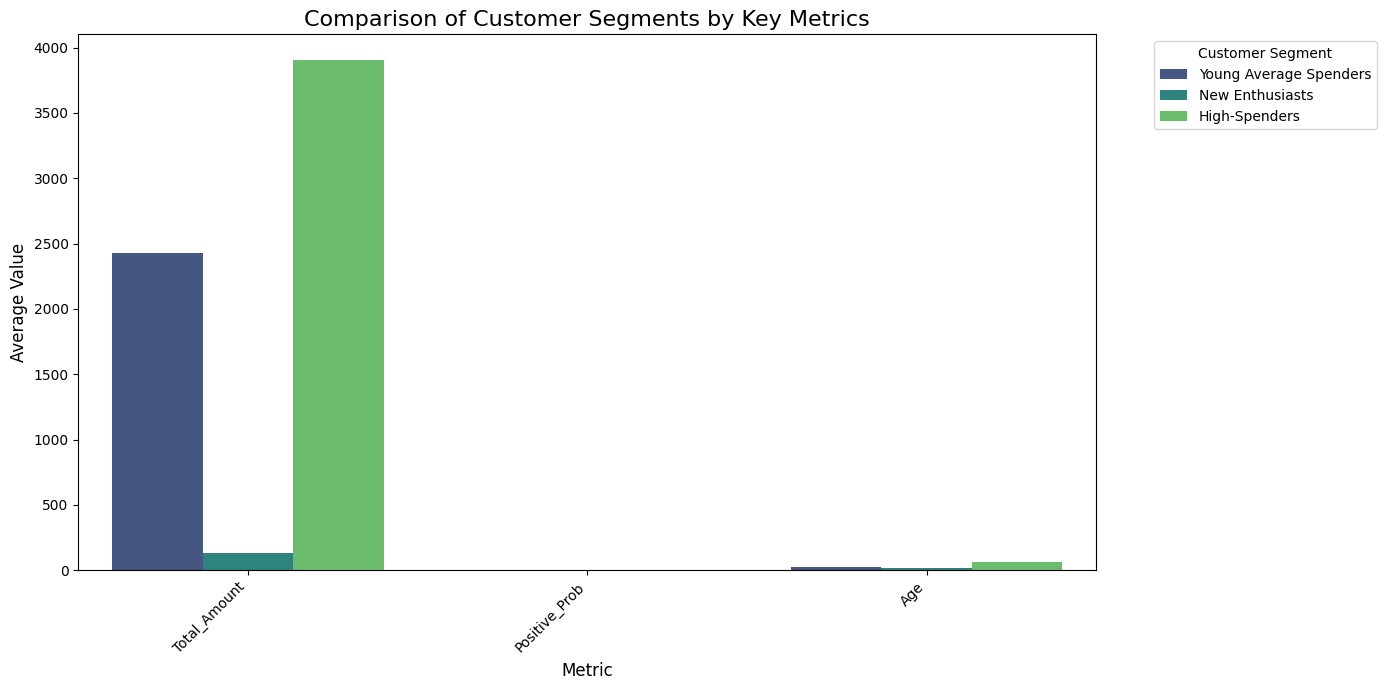

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# The selected_clusters DataFrame is available from the previous step:
# selected_clusters looks like this:
#                            Total_Amount  Positive_Prob    Age
# Cluster_ID
# Young Average Spenders          2426.94           0.48  21.56
# New Enthusiasts                  132.11           1.00  18.75
# Disgruntled High-Spenders       3905.76           0.00  64.60

# Reset index to make 'Cluster_ID' a regular column for plotting
plot_df = selected_clusters.reset_index()

# Melt the DataFrame to long format for easier plotting with seaborn
melted_df = plot_df.melt(id_vars='Cluster_ID', var_name='Metric', value_name='Value')

plt.figure(figsize=(14, 7))
sns.barplot(x='Metric', y='Value', hue='Cluster_ID', data=melted_df, palette='viridis')

plt.title('Comparison of Customer Segments by Key Metrics', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Customer Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Create Bar Chart

### Subtask:
Generate a grouped bar chart using matplotlib and seaborn to visually compare the average 'Total_Amount', 'Positive_Prob', and 'Age' across the selected customer segments.


## Summary:

### Data Analysis Key Findings
*   **Young Average Spenders** (Cluster ID 0) have an average total amount spent of \$2426.94, an average positive probability of 0.48, and an average age of 21.56.
*   **New Enthusiasts** (Cluster ID 3) show the lowest average total amount spent at \$132.11, but the highest positive probability at 1.00, with an average age of 18.75.
*   **Disgruntled High-Spenders** (Cluster ID 590) exhibit the highest average total amount spent at \$3905.76, the lowest positive probability at 0.00, and are the oldest segment with an average age of 64.60.

### Insights or Next Steps
*   The stark differences in 'Total\_Amount' and 'Positive\_Prob' across segments (e.g., high spending but zero positive probability for 'Disgruntled High-Spenders' versus low spending but 100% positive probability for 'New Enthusiasts') highlight diverse customer behaviors that warrant further investigation into their specific needs and pain points.
*   The next step will be to visualize these differences using a grouped bar chart to allow for easier comparison and identification of key patterns among these customer segments.
